In [5]:
## Package Installation
#require(nmecr)

Installing package into 'C:/Users/mrina/Documents/R/win-library/4.1'
(as 'lib' is unspecified)

Warning message:
"package 'ggplot' is not available for this version of R

A version of this package for your version of R might be available elsewhere,
see the ideas at
https://cran.r-project.org/doc/manuals/r-patched/R-admin.html#Installing-packages"
Warning message:
"package 'openxlsx' is in use and will not be installed"


In [8]:
## Load in Data

eload_data <- readxl::read_xlsx("Processed Data/Processed Eload - Electric - kWh.xlsx")
temp_data <- readxl::read_xlsx("Processed Data/Processed Temp.xlsx")
occupancy <- readxl::read_xlsx("Processed Data/Processed Pct_Occupancy.xlsx")

In [40]:
simple_df_year2 <- nmecr::create_dataframe(eload_data, temp_data, start_date = "2020-04-01",
                                          end_date = "2021-04-01", 
                                          convert_to_data_interval = "Daily")

In [41]:
basic_model <- nmecr::model_with_TOWT(simple_df_year2, model_input_options = nmecr::assign_model_inputs())

In [42]:
## Summary Stats - 1

stats <- nmecr::calculate_summary_statistics(basic_model)
sav_unc <- nmecr::calculate_savings_and_uncertainty(modeled_object = basic_model,
                                        model_summary_statistics = stats,
                                        confidence_level = 90)

print(stats)

print(sav_unc)

  R_squared Adjusted_R_squared CVRMSE %       NDBE %       NMBE % #Parameters
1       0.8               0.79     8.68 1.577082e-14 1.635827e-14          13
  deg_of_freedom
1            349
$savings_summary_df
  savings_fraction savings_uncertainty savings_frac_for_50pct_uncertainty
1              0.1           0.2841398                         0.05682796
  confidence_level
1               90



In [43]:
baseline_scatter_df <- basic_model$training_data[, c("eload", "temp", "model_fit")]
names(baseline_scatter_df) <- c("Energy", "Temp", "Model Fit")
baseline_scatter_df <- tidyr::pivot_longer(baseline_scatter_df,
                                           cols = c("Energy", "Model Fit"))


baseline_ts_df <- basic_model$training_data[, c("eload", "time", "model_fit")]
names(baseline_ts_df) <- c("Energy", "Time", "Model Fit")
baseline_ts_df <- tidyr::pivot_longer(baseline_ts_df,
                                           cols = c("Energy", "Model Fit"))

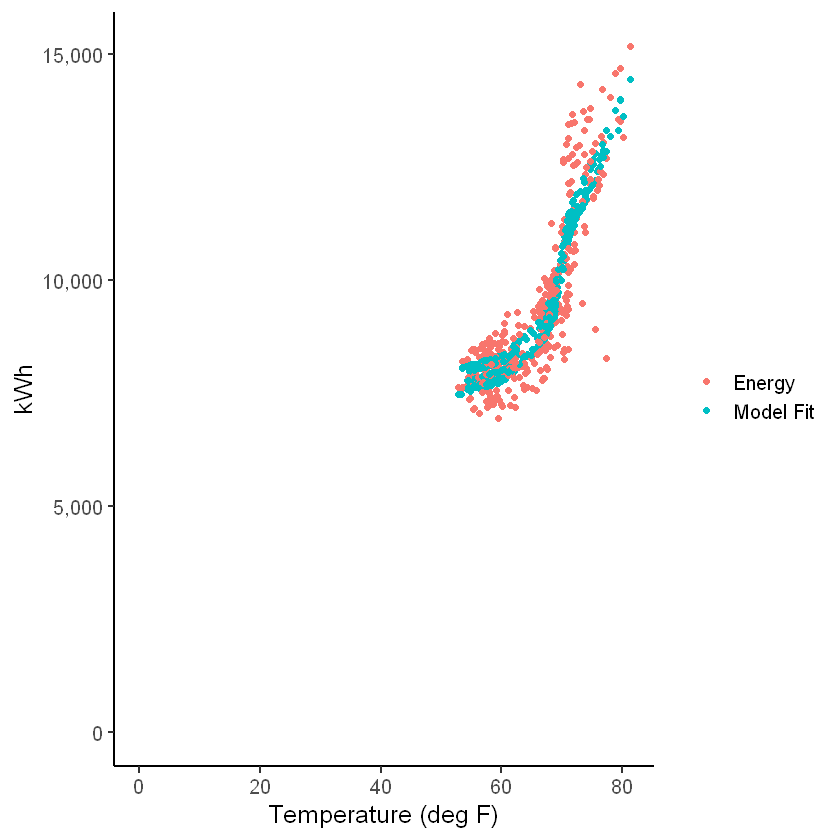

In [44]:
ggplot2::ggplot(baseline_scatter_df) +
  aes(x = Temp, y = value, color = name) +
  geom_point() +
  scale_y_continuous(limits = c(0, NA), labels = scales::comma) + ylab("kWh") +
  scale_x_continuous(limits = c(0, NA)) + xlab("Temperature (deg F)") +
#  scale_color_manual(values = c("#E76B15", "#15B4E7")) +
  theme_classic(base_size = 15) + theme(legend.title = element_blank())

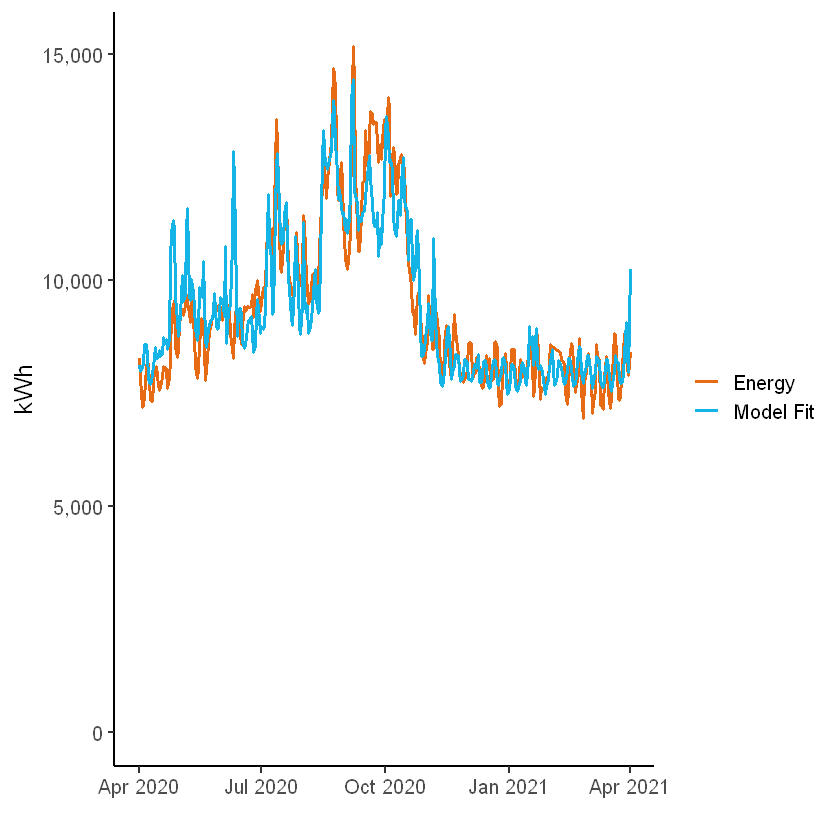

In [45]:
ggplot2::ggplot(baseline_ts_df) +
  aes(x = Time, y = value, color = name) +
  geom_line(size = 1) +
  scale_y_continuous(limits = c(0, NA), labels = scales::comma) + ylab("kWh") +
  xlab("") +
  scale_color_manual(values = c("#E76B15", "#15B4E7")) +
  theme_classic(base_size = 15) + theme(legend.title = element_blank())

In [47]:
prediction_df <- nmecr::create_dataframe(eload_data, temp_data, start_date = "2019-04-01",
                                          end_date = "2021-04-01", convert_to_data_interval = "Daily")

In [48]:
model_predictions <- nmecr::calculate_model_predictions(training_data = simple_df_year2,
                                                           prediction_data = prediction_df,
                                                           modeled_object = basic_model)

In [49]:
predictions_scatter_df <- model_predictions[, c("eload", "temp", "predictions")]
names(predictions_scatter_df) <- c("Energy", "Temp", "Predictions")
predictions_scatter_df <- tidyr::pivot_longer(predictions_scatter_df,
                                           cols = c("Energy", "Predictions"))

predictions_ts_df <- model_predictions[, c("eload", "time", "predictions")]
names(predictions_ts_df) <- c("Energy", "Time", "Predictions")
predictions_ts_df <- tidyr::pivot_longer(predictions_ts_df,
                                      cols = c("Energy", "Predictions"))

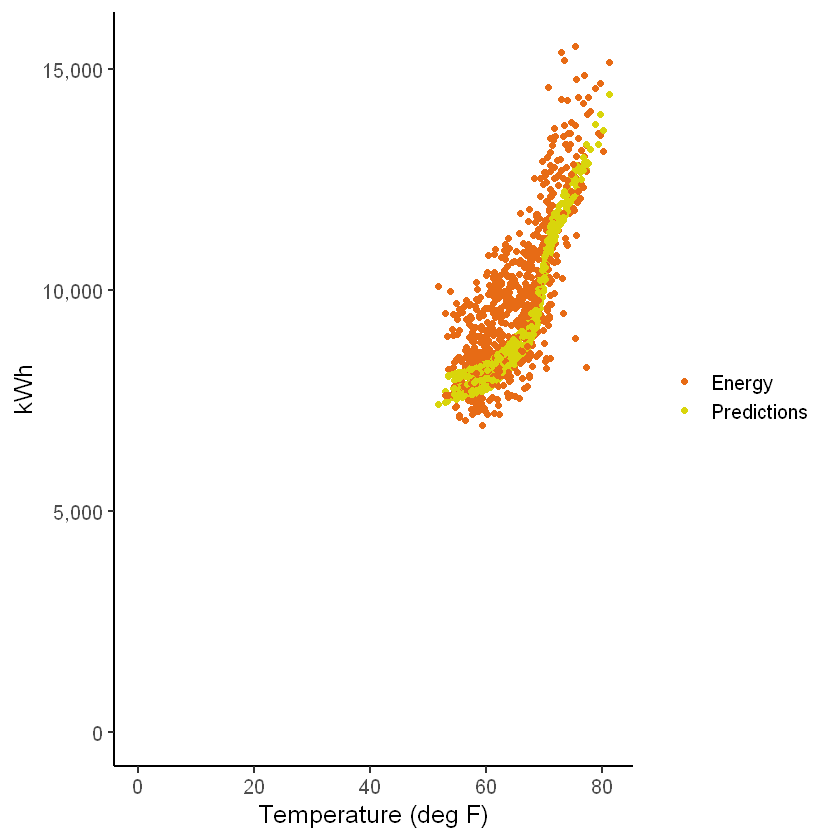

In [50]:
ggplot2::ggplot(predictions_scatter_df) +
  aes(x = Temp, y = value, color = name) +
  geom_point() +
  scale_y_continuous(limits = c(0, NA), labels = scales::comma) + ylab("kWh") +
  scale_x_continuous(limits = c(0, NA)) + xlab("Temperature (deg F)") +
  scale_color_manual(values = c("#E76B15", "#D9D50B")) +
  theme_classic(base_size = 15) + theme(legend.title = element_blank())

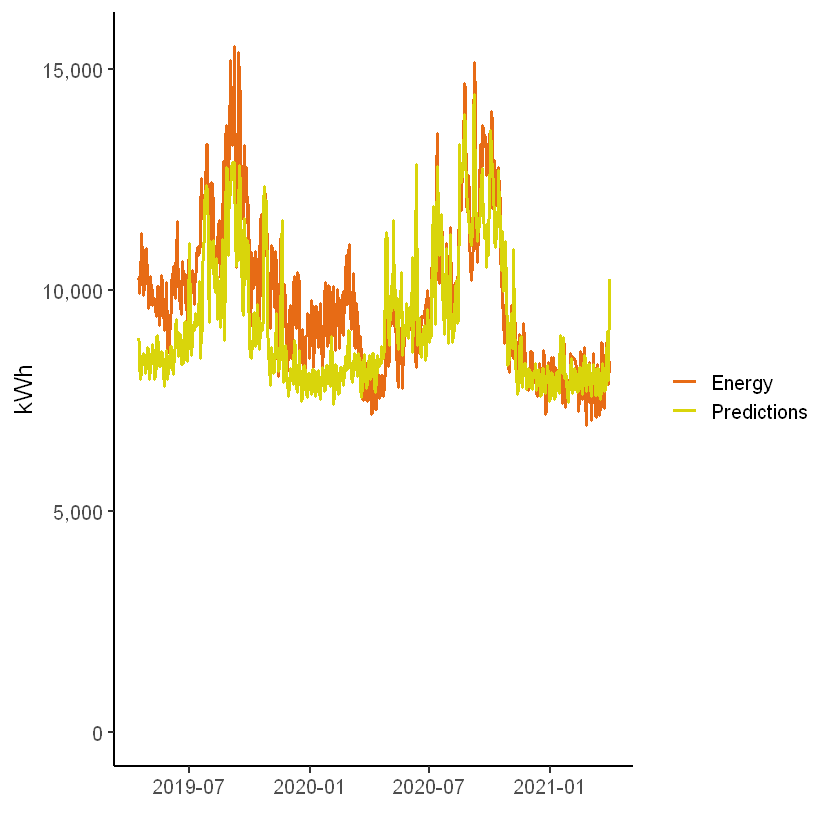

In [51]:
ggplot2::ggplot(predictions_ts_df) +
  aes(x = Time, y = value, color = name) +
  geom_line(size = 1) +
  scale_y_continuous(limits = c(0, NA), labels = scales::comma) + ylab("kWh") +
  xlab("") +
  scale_color_manual(values = c("#E76B15", "#D9D50B")) +
  theme_classic(base_size = 15) + theme(legend.title = element_blank())

Warning message:
"Removed 354 row(s) containing missing values (geom_path)."


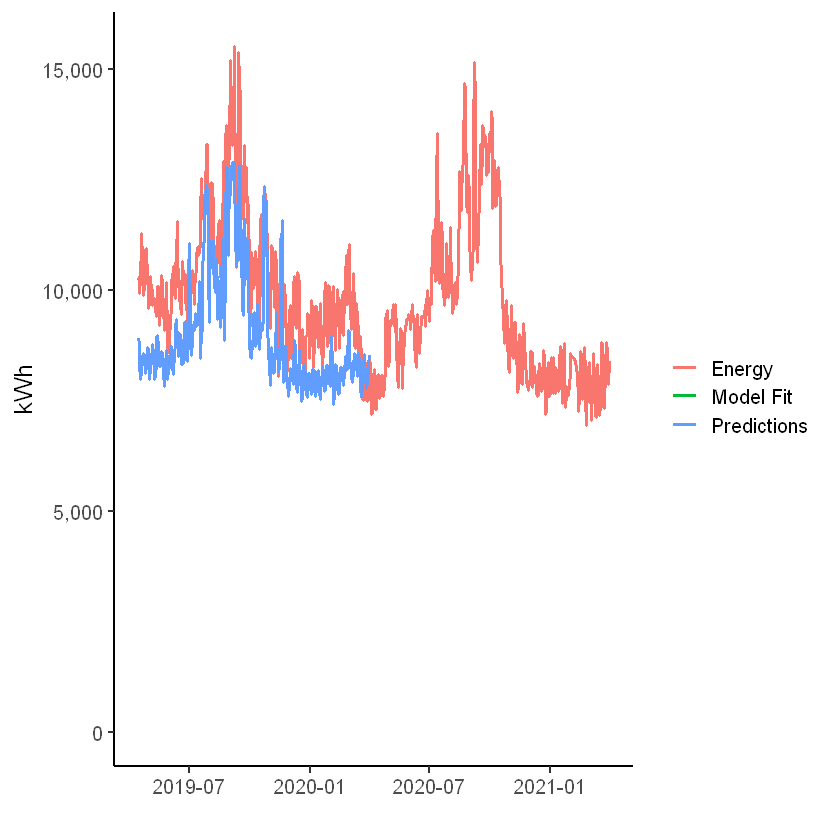

In [52]:
all_data <- dplyr::bind_rows(basic_model$training_data,
                             model_predictions)


all_data_ts_df <- all_data[, c("eload", "time", "predictions", "model_fit")]
names(all_data_ts_df) <- c("Energy", "Time", "Predictions", "Model Fit")
all_data_ts_df <- tidyr::pivot_longer(all_data_ts_df,
                                         cols = c("Energy", "Predictions", "Model Fit"))

ggplot2::ggplot(all_data_ts_df) +
  aes(x = Time, y = value, color = name) +
  geom_line(size = 1) +
  scale_y_continuous(limits = c(0, NA), labels = scales::comma) + ylab("kWh") +
  xlab("") +
  # scale_color_manual(values = c("#E76B15", "#D9D50B")) +
  theme_classic(base_size = 15) + theme(legend.title = element_blank())

#### Add in the occupancy variable

In [53]:
baseline_df <- nmecr::create_dataframe(eload_data, temp_data, additional_independent_variables = occupancy,
                                       additional_variable_aggregation = c(median),
                                       start_date = "2020-04-01",
                                          end_date = "2021-04-01")

In [54]:
updated_prediction_df <- nmecr::create_dataframe(eload_data, temp_data, additional_independent_variables = occupancy,
                                       additional_variable_aggregation = c(median),
                                       start_date = "2019-04-01",
                                          end_date = "2020-04-01")

In [55]:
baseline_model <- nmecr::model_with_TOWT(baseline_df, model_input_options = nmecr::assign_model_inputs())

In [56]:
updated_predictions <- nmecr::calculate_model_predictions(training_data = baseline_df,
                                                           prediction_data = updated_prediction_df,
                                                           modeled_object = baseline_model)

Warning message:
"Removed 670 row(s) containing missing values (geom_path)."


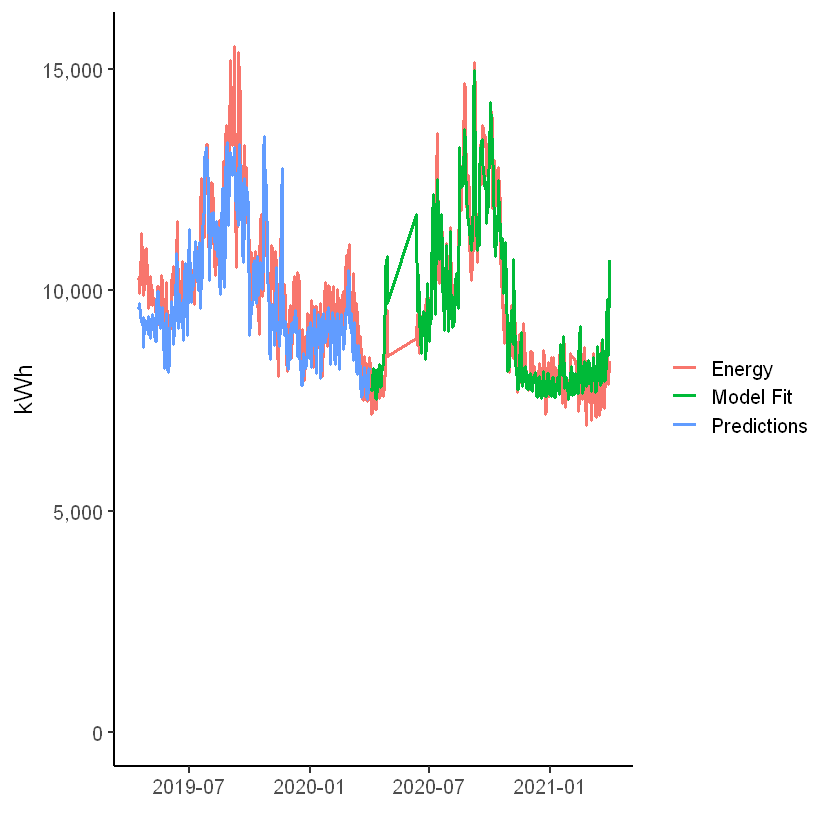

In [57]:
all_data <- dplyr::bind_rows(baseline_model$training_data,
                             updated_predictions)


all_data_ts_df <- all_data[, c("eload", "time", "predictions", "model_fit")]
names(all_data_ts_df) <- c("Energy", "Time", "Predictions", "Model Fit")
all_data_ts_df <- tidyr::pivot_longer(all_data_ts_df,
                                         cols = c("Energy", "Predictions", "Model Fit"))

ggplot2::ggplot(all_data_ts_df) +
  aes(x = Time, y = value, color = name) +
  geom_line(size = 1) +
  scale_y_continuous(limits = c(0, NA), labels = scales::comma) + ylab("kWh") +
  xlab("") +
  # scale_color_manual(values = c("#E76B15", "#D9D50B")) +
  theme_classic(base_size = 15) + theme(legend.title = element_blank())

In [59]:
summary.lm(baseline_model$model_unoccupied)


Call:
lm(formula = training_data$eload ~ ., data = dframe_unocc, subset = !ok_occ, 
    weights = model_input_options$train_weight_vec, na.action = na.exclude)

Residuals:
    Min      1Q  Median      3Q     Max 
-2806.5  -379.1     9.1   447.9  2076.6 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)   7979.646   3698.881   2.157   0.0318 *  
pct_occupancy 1514.848    183.162   8.271 4.18e-15 ***
ftow2          290.719    147.599   1.970   0.0498 *  
ftow3          311.562    150.570   2.069   0.0394 *  
ftow4          111.145    151.820   0.732   0.4647    
ftow5         -135.694    151.221  -0.897   0.3703    
ftow6         -194.202    150.992  -1.286   0.1994    
ftow7         -182.262    143.993  -1.266   0.2066    
X1              -5.256     65.953  -0.080   0.9365    
X2              64.515     82.224   0.785   0.4333    
X3              35.293     47.434   0.744   0.4574    
X4             305.646     51.216   5.968 6.67e-09 ***
X5             